- This file creates model with MORE labelled data (Coded Sentences Drawn from Civic Center's Research and Taylor (1892_labeled_sentences.csv). Renamed "Label" column to "jim_crow".
- Added 11 updated files with correct splitting and coded by Axton : 1868_24-25_updated, 1868_143-145_updated, 1868_146-151_updated, 1877_571-586_updated.csv, 1884_24-26_updated.csv, 1886-87_1031-1034_updated.csv, 1886-87_1072-1074_updated.csv,1868_24-25_updated, 1896_63act_updated, 1907_518-522_updated, 1925_324act_updated, shared_base_training_set_v2.csv (from UNC)
- Converted the excel files coded by Axton to csv
- Renamed the above files to make the naming consistent (- replaced by _, added 'labeled_sentences')
- Renamed the column 'Coding (Axton)" of Civic Center data to 'jim_crow' , 'Act' to 'sentence' and 'Year' to 'year' for consistency
- Added column state = 'South Carolina' in all Civic Center coded files
- Replaced the 'year' values in file 1886_87_1031-1034.csv from '1886-87' to 1886 and '1868_146-151_updated.csv' from '1868-69' to 1868
- Changed case in some column names (upper to lower)
- Read "UNC_shared_base_training_set_v2.csv" file differently to perform some filteration as mentioned by Matthew Jansen (UNC) 
- CASE 1: Training and testing model on combined data of UNC and USC
- CASE 2: Training model on UNC data and testing model on USC data

- **Used SMOTEN to rebalance the imbalanced dataset and removed stopwords but the model performance did not improve.**
- **This code also predicts labels for the WHOLE CORPUS**

## Case 1: Training and testing model on both USC and UNC data

### Import neccessary libraries

In [1]:
# data reading libraries
import numpy as np
import pandas as pd
from pathlib import Path

#Saving model so that we don't have to run it every time we open this notebook
import pickle 

# Text Libraries
import re
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords') 

# Machine Learning Libraries
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTEN
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

#Model Tuning Libraries
from hyperopt import hp, tpe, space_eval, Trials
from hyperopt.fmin import fmin

#Evaluation Libraries
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Supression
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vandana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read the data and store in dataframe

In [2]:
# Read data from the folder "LabeledData"
new_df = pd.DataFrame()

for file in Path("LabeledData_UNC_USC_Nov2023").glob('*.csv'):
    if str(file).find("base") != -1 :
        df1 = pd.read_csv(file)       # reading the "UNC_shared_base_training_set_v2.csv" file and store it in dataframe df1
    else: 
        df = pd.read_csv(file, usecols=['year', 'state','sentence', 'jim_crow'])
        new_df = new_df.append(df, ignore_index = True)

In [3]:
# Read first 5 rows of "UNC_shared_base_training_set_v2.csv" file whose columns are different from other csv files
df1[['jim_crow']] = df1[['jim_crow']].astype(int) # Change the datatype of jim_crow" to int in df1 (it is 0.0, 1.0, 2.0 currently)
df1.head()

,corpus_section_id,source,law_type,UNC_training,state,sentence,section_sents,char_len,reviewer,jim_crow,jim_crow_type,year,corpus_sentence_id
0,1947_session laws_979_2,murray,session laws,1.0,NORTH CAROLINA,Subject only to restrictions and conditions no...,1.0,779.0,NaN,1,explicit,1947,NaN
1,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,Powers and duties of Commission.,10.0,32.0,Axton,0,explicit,1935,NaN
2,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,10.0,146.0,Axton,0,explicit,1935,NaN
3,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",10.0,53.0,Axton,0,explicit,1935,NaN
4,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"and instructional supplies, which are, or may ...",10.0,218.0,Axton,0,explicit,1935,NaN


In [4]:
# find length of df1
len(df1)

10231

#### Only select rows which have a 'jim_crow' value of either 0 or 1
df.loc[df.jim_crow.isin([0,1]), :]

#### Only select rows which have a 'jim_crow_type' value of 'extrinsic' or 'implicit'
df.loc[df.jim_crow_type.isin(["extrinsic","implicit"]), :]

#### Only select rows which DONT have a 'jim_crow_type' value of 'extrinsic' or 'implicit' by using '~'
df.loc[~df.jim_crow_type.isin(["extrinsic","implicit"]), :]

In [5]:
# Only select those rows which have value of either 0 or 1 in "jim_crow" column AND do not have value of "extrinsic" or 
# "intrinsic" in "jim_crow_type" column ---- as suggested by Matt Jansen (UNC)
df1_good = df1.loc[(df1.jim_crow.isin([0,1])) & (~df1.jim_crow_type.isin(["extrinsic","implicit"])),:].copy()
df1_good.head()

,corpus_section_id,source,law_type,UNC_training,state,sentence,section_sents,char_len,reviewer,jim_crow,jim_crow_type,year,corpus_sentence_id
0,1947_session laws_979_2,murray,session laws,1.0,NORTH CAROLINA,Subject only to restrictions and conditions no...,1.0,779.0,NaN,1,explicit,1947,NaN
1,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,Powers and duties of Commission.,10.0,32.0,Axton,0,explicit,1935,NaN
2,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,10.0,146.0,Axton,0,explicit,1935,NaN
3,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",10.0,53.0,Axton,0,explicit,1935,NaN
4,1935_public laws_423_3,murray,public laws,1.0,NORTH CAROLINA,"and instructional supplies, which are, or may ...",10.0,218.0,Axton,0,explicit,1935,NaN


In [6]:
# Create a new dataframe from df1_good that has columns same as new_df
new_df1 = df1_good[['year', 'state', 'sentence', 'jim_crow']]
new_df1

,year,state,sentence,jim_crow
0,1947,NORTH CAROLINA,Subject only to restrictions and conditions no...,1
1,1935,NORTH CAROLINA,Powers and duties of Commission.,0
2,1935,NORTH CAROLINA,The said Textbook Purchase and Rental Commissi...,0
3,1935,NORTH CAROLINA,"Acquire by contract, and/or purchase, such tex...",0
4,1935,NORTH CAROLINA,"and instructional supplies, which are, or may ...",0
...,...,...,...,...
10225,1909,NORTH CAROLINA,On behalf of the general welfare of the city o...,0
10226,1895,NORTH CAROLINA,"The clerk of the commissioners, on or before t...",1
10228,1899,NORTH CAROLINA,The township school trustees shall divide thei...,0
10229,1899,NORTH CAROLINA,They shall consult the convenience and necessi...,1


### Data Cleaning and Exploration

In [7]:
# display first 5 rows of the data new_df
new_df.head()

,year,state,sentence,jim_crow
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0


In [8]:
#replace '1886-87' in "year" column by 1886 and '1868-69' by 1868
new_df.replace('1886-87', '1886', inplace=True)
new_df.replace('1868-69', '1868', inplace=True)
new_df[new_df['year'] == '1868-69'].head() # emplty dataframe because we have replaced "1886-87" by "1886"

,year,state,sentence,jim_crow


In [9]:
# find the size of each dataframe
print(" The length of new_df is", len(new_df))
print(" The length of new_df1 is", len(new_df1))

 The length of new_df is 8978
 The length of new_df1 is 9492


In [10]:
# Check how many entries are null or empty in the two datasets
print(new_df.isnull().sum().sum())
print(new_df1.isnull().sum().sum())

0
0


In [11]:
# find the data types of columns of new_df1 and new_df
print("Column datatypes of new_df are below: \n", new_df.dtypes)
print("Column datatypes of new_df1 are below: \n", new_df1.dtypes)

Column datatypes of new_df are below: 
 year        object
state       object
sentence    object
jim_crow     int64
dtype: object
Column datatypes of new_df1 are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object


Make sure that the data type of the two dataframes are SAME as we are going to append the datasets to create ONE large dataset

In [12]:
# Change the datatype of "year" and "jim_crow" to string in new_df1 
new_df1[['jim_crow']] = new_df1[['jim_crow']].astype(int)
#new_df1[['year']] = new_df1[['year']].astype(str)

# # Change the datatype of 'year' to string in new_df
new_df[['year']] = new_df[['year']].astype(int)

In [13]:
# find the data types of columns of new_df1 and new_df after changing
print("Column datatypes of new_df are below: \n", new_df.dtypes)
print("Column datatypes of new_df1 are below: \n", new_df1.dtypes)

Column datatypes of new_df are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object
Column datatypes of new_df1 are below: 
 year         int64
state       object
sentence    object
jim_crow     int64
dtype: object


In [14]:
new_df.year.unique()


array([1896, 1907, 1886, 1877, 1879, 1898, 1900, 1903, 1904, 1905, 1908,
       1909, 1910, 1911, 1912, 1914, 1915, 1916, 1917, 1918, 1920, 1924,
       1926, 1928, 1930, 1934, 1872, 1878, 1906, 1891, 1923, 1935, 1937,
       1938, 1939, 1940, 1943, 1944, 1945, 1947, 1933, 1927, 1925, 1913,
       1899, 1901, 1941, 1949, 1889, 1887, 1885, 1883, 1881, 1880, 1897,
       1893, 1895, 1929, 1931, 1919, 1955, 1959, 1967, 1965, 1957, 1869,
       1963, 1951, 1868, 1961, 1870, 1921, 1953, 1876, 1871, 1866, 1874,
       1873, 1956, 1888, 1892, 1884])

#### Append the 2 datasets to create a big labeled dataset

In [15]:
# Create a large dataset with the 2 separate datasets
combined_df = new_df.append(new_df1,ignore_index = True)

#find the length of combined dataset
print(len(combined_df))

18470


In [16]:
# save the combined data to csv file
combined_df.to_csv("combined.csv")

In [17]:
# Convert column 'sentence' to lowercase use map()
combined_df['sentence'] = combined_df['sentence'].map(str.lower)
combined_df

,year,state,sentence,jim_crow
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0
...,...,...,...,...
18465,1909,NORTH CAROLINA,on behalf of the general welfare of the city o...,0
18466,1895,NORTH CAROLINA,"the clerk of the commissioners, on or before t...",1
18467,1899,NORTH CAROLINA,the township school trustees shall divide thei...,0
18468,1899,NORTH CAROLINA,they shall consult the convenience and necessi...,1


In [18]:
# Count of North Carolina and SOuth Carolina sentences
count_df = combined_df.groupby('state').count()
count_df

,year,sentence,jim_crow
state,,,
NORTH CAROLINA,14913,14913,14913
SOUTH CAROLINA,3557,3557,3557


In [19]:
# find length of each sentence
combined_df['sent_length'] = combined_df['sentence'].str.len()
combined_df

,year,state,sentence,jim_crow,sent_length
0,1896,SOUTH CAROLINA,it shall be the duty of each county treasurer ...,0,533
1,1896,SOUTH CAROLINA,all moneys disbursed by any county treasurer o...,0,249
2,1896,SOUTH CAROLINA,each county treasurer shall make out and forwa...,0,808
3,1896,SOUTH CAROLINA,the county treasurer shall carry forward all s...,0,320
4,1896,SOUTH CAROLINA,"it shall be unlawful for any county treasurer,...",0,318
...,...,...,...,...,...
18465,1909,NORTH CAROLINA,on behalf of the general welfare of the city o...,0,365
18466,1895,NORTH CAROLINA,"the clerk of the commissioners, on or before t...",1,477
18467,1899,NORTH CAROLINA,the township school trustees shall divide thei...,0,136
18468,1899,NORTH CAROLINA,they shall consult the convenience and necessi...,1,282


In [20]:
# find the max and min length of the sentence
print(" The longest sentence is of length:", combined_df['sent_length'].max())

# find the index of the row with longest sentence
combined_df.index[combined_df['sent_length'] == 8889]

 The longest sentence is of length: 8889


Int64Index([2983, 10561], dtype='int64')

In [21]:
combined_df.iloc[5298,:]

year                                                        1909
state                                             NORTH CAROLINA
sentence       all laws and clauses of laws in conflict with ...
jim_crow                                                       0
sent_length                                                   75
Name: 5298, dtype: object

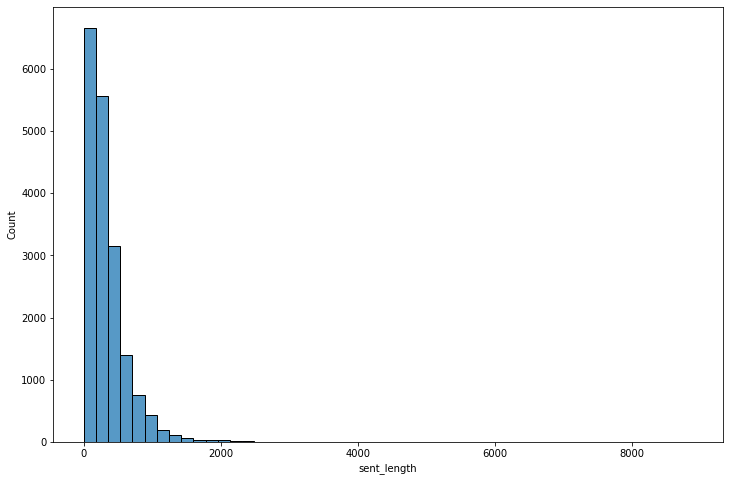

In [22]:

fig, ax = plt.subplots(1,1, figsize=(12,8))
# Histogram for the sentence length
sns.histplot(data=df, x=combined_df['sent_length'], bins = 50, ax=ax)

In [23]:
# find the rows whose sentence length is less than 27 words
combined_df_27char = combined_df[combined_df['sent_length'] < 27]
#combined_df_27char.to_csv("combined_df_27char.csv")

- The number of sentences less than 25 characters are 463 and they are all labeled as 0 except one (labeled 2). So, we can delete all senetences whose length are less than 25.
- The number of sentences less than 27 characters are 549 and they are all labeled as 0 except three (one labeled 1, two lableled 2). Since we do not want to delete any sentence coded as 1, we will delete all sentences less than 27 characters.

#### Remove all the sentences with < 27 characters. Create dataset with >= 27 characaters

In [24]:
# Remove all the sentences whose length is <= characters
df_updated = combined_df[combined_df['sent_length'] >= 27]
print(" Number of rows in the reduced dataset:", len(df_updated))

 Number of rows in the reduced dataset: 17972


In [25]:
# find the data type of reduced dataframe columns
df_updated.dtypes

year            int64
state          object
sentence       object
jim_crow        int64
sent_length     int64
dtype: object

In [26]:
# Find the number of sentences with labels "0", "1", and "2"
df_0 = df_updated[df_updated['jim_crow'] == 0]
df_1 = df_updated[df_updated['jim_crow'] == 1]
df_2 = df_updated[df_updated['jim_crow'] == 2]

print("Number of sentences that are NOT jim crow =", len(df_0))
print("Number of jim crow sentences =", len(df_1))
print("Number of undecided sentences =", len(df_2))

Number of sentences that are NOT jim crow = 13223
Number of jim crow sentences = 4100
Number of undecided sentences = 649


In [27]:
df_updated.dtypes

year            int64
state          object
sentence       object
jim_crow        int64
sent_length     int64
dtype: object

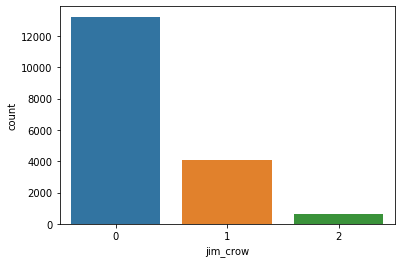

In [28]:
from seaborn import countplot

# Plot the distribution of the target (=1 that is jim_crow)
countplot(x=df_updated['jim_crow'])

In [29]:
# Check for missing values
df_updated.isnull().sum().sum()

0

#### Removing stopwords from the sentences

In [30]:
stopWords = stopwords.words("english")

# Define a function to remove stop words from a sentence 
def remove_stop_words(sentence): 
  # Split the sentence into individual words 
    words = sentence.split() 
  
  # Use a list comprehension to remove stop words 
    filtered_words = [word for word in words if word not in stopWords] 
  
  # Join the filtered words back into a sentence 
    return ' '.join(filtered_words)

In [31]:
# Remove stopwords from the 'sentence' column of the dataframe
p=[]
for i in df_updated['sentence']:
    p.append(remove_stop_words(i))
df_updated['sentence']=p
df_updated['sentence']

0        shall duty county treasurer report monthly, fi...
1        moneys disbursed county treasurer account scho...
2        county treasurer shall make forward state supe...
3        county treasurer shall carry forward sums hand...
4        shall unlawful county treasurer, county audito...
                               ...                        
18465    behalf general welfare city winston, good orde...
18466    clerk commissioners, first monday november lis...
18467    township school trustees shall divide respecti...
18468    shall consult convenience necessities race set...
18469    treasurer wilkes county hereby authorized pay ...
Name: sentence, Length: 17972, dtype: object

### Split the data into 'features' and 'target' for machine learning 

In [32]:
# Split data
features = df_updated[['year', 'sentence']]
target = df_updated['jim_crow']

In [33]:
print(features.shape, target.shape)

(17972, 2) (17972,)


In [34]:
features

,year,sentence
0,1896,"shall duty county treasurer report monthly, fi..."
1,1896,moneys disbursed county treasurer account scho...
2,1896,county treasurer shall make forward state supe...
3,1896,county treasurer shall carry forward sums hand...
4,1896,"shall unlawful county treasurer, county audito..."
...,...,...
18465,1909,"behalf general welfare city winston, good orde..."
18466,1895,"clerk commissioners, first monday november lis..."
18467,1899,township school trustees shall divide respecti...
18468,1899,shall consult convenience necessities race set...


### Machine Learning: XGBoost 

- Splitting test and training set in 20|80 ratio
- Using default values of the parameter
- Training and test set contains mixed of NC and SC sentences
- Resample training data using imblearn SMOTEN as the dataset is very imbalanced - using SMOTEN because our dataset is purely categorical (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html#imblearn.over_sampling.SMOTEN)

In [35]:
# Randomly split X and y into training (80%) and test(20%) sets

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.2, 
                                                    random_state = 13)

In [36]:
print("......TRAINING SET....")
print(" Size of X_train is: ", X_train.shape)
print(" Size of y_train is: ", y_train.shape)
print("......TEST SET....")
print(" Size of X_test is: ", X_test.shape)
print(" Size of y_test is: ", y_test.shape)


......TRAINING SET....
 Size of X_train is:  (14377, 2)
 Size of y_train is:  (14377,)
......TEST SET....
 Size of X_test is:  (3595, 2)
 Size of y_test is:  (3595,)


#### Count of 0,1,2 in training set BEFORE resampling using SMOTEN

In [37]:
# Counting 0,1,2 in y_train 
np.array(np.unique(y_train, return_counts=True)).T

array([[    0, 10549],
       [    1,  3307],
       [    2,   521]])

In [38]:
X_train.dtypes

year         int64
sentence    object
dtype: object

#### Resample the data using SMOTEN

In [39]:
sm = SMOTEN(random_state=13)
X_train, y_train = sm.fit_resample(X_train, np.array(y_train))
len(X_train)

31647

#### Count of 0,1,2 in training set AFTER resampling using SMOTEN

In [40]:
# count of 0,1,2 after using SMOTEN
np.array(np.unique(y_train, return_counts=True)).T

array([[    0, 10549],
       [    1, 10549],
       [    2, 10549]])

### Create pipeline for the analysis

In [41]:
# class LengthExtractor(BaseEstimator, TransformerMixin):   
#     def compute_length(self, text):
#         sentence_list = word_tokenize(text)
#         return len(sentence_list) 
#     def fit(self, x, y=None):
#         return self
#     def transform(self, X):
#         X_length = pd.Series(X).apply(self.compute_length)
#         return pd.DataFrame(X_length)

class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def transform(self, X, **transform_params):
        out = X[self.columns].copy()
        return out
    def fit(self, X, y=None, **fit_params):
        return self

##### Bayesian Hyperparameter search with HyperOpt

In [42]:
pipeline = Pipeline([

        ('features', FeatureUnion([

            # Extract features
            ('text_pipeline', Pipeline([
                ('get_text', SelectColumnsTransformer("sentence")),
                ('vect', CountVectorizer(decode_error = "ignore",
                      min_df = 2, max_df = 0.8)),
                ('tfidf', 'passthrough'),
            ])),
#             ('text_len', Pipeline([
#                 ('get_text', SelectColumnsTransformer("sentence")),
#                 ('length', LengthExtractor())
#             ])),
            ('metadata', SelectColumnsTransformer(['year']))
        ])),
        ('dlf',XGBClassifier(tree_method="hist"))
])

In [43]:
def objective(params):
    params['features__text_pipeline__vect__min_df'] = int(params['features__text_pipeline__vect__min_df'])
    params['dlf__max_depth'] = int(params['dlf__max_depth'])
    params['dlf__min_child_weight'] = int(params['dlf__min_child_weight'])
    params['dlf__scale_pos_weight'] = int(params['dlf__scale_pos_weight'])
    pipeline.set_params(**params)
    
    score = 1-cross_val_score(pipeline, X_train, y_train, scoring=make_scorer(f1_score, average="weighted"),
                              n_jobs=-1).mean()
    #print("F1 {:.4f} params {}".format((1-score), params))
    return score

space = {
    'features__text_pipeline__vect__min_df': hp.quniform ('features__text_pipeline__vect__min_df',2,20,1),
    'features__text_pipeline__vect__lowercase': hp.choice('features__text_pipeline__vect__lowercase',[True,False]),
    'features__text_pipeline__vect__ngram_range': hp.choice('features__text_pipeline__vect__ngram_range',[(1,1),(1,2),(1,3),(1,4)]),
    'features__text_pipeline__vect__max_df': hp.uniform('features__text_pipeline__vect__max_df',0.6,0.8),
#     'features__text_len':hp.choice('features__text_len',[Pipeline([
#             ('get_text', SelectColumnsTransformer("sentence")),
#             ('length', LengthExtractor())
#         ])]),
    'dlf__max_depth': hp.quniform('dlf__max_depth', 2, 10, 1),
    'dlf__min_child_weight': hp.quniform('dlf__min_child_weight', 1, 5, 1),
    'dlf__colsample_bytree': hp.uniform('dlf__colsample_bytree', 0.3, 1.0),
    'dlf__learning_rate': hp.uniform('dlf__learning_rate', 0.05, 1),
    'dlf__scale_pos_weight': hp.quniform('dlf__scale_pos_weight',1,8,1),
    'dlf__gamma': hp.uniform('dlf__gamma',0,2)
    
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100, #actual fit was run with 1000 evals
           trials=trials)

100%|██████████| 100/100 [16:59<00:00, 10.20s/trial, best loss: 0.03356109989511202]


In [44]:
model_params = space_eval(space, best)
model_params['features__text_pipeline__vect__min_df'] = int(model_params['features__text_pipeline__vect__min_df'])
model_params['dlf__max_depth'] = int(model_params['dlf__max_depth'])
model_params['dlf__min_child_weight'] = int(model_params['dlf__min_child_weight'])
# model_params['dlf__scale_pos_weight'] = int(model_params['dlf__scale_pos_weight'])

In [45]:
model_params

{'dlf__colsample_bytree': 0.9398356320197676,
 'dlf__gamma': 0.3619796155783562,
 'dlf__learning_rate': 0.1916263824269357,
 'dlf__max_depth': 9,
 'dlf__min_child_weight': 1,
 'dlf__scale_pos_weight': 2.0,
 'features__text_pipeline__vect__lowercase': False,
 'features__text_pipeline__vect__max_df': 0.7413824318299232,
 'features__text_pipeline__vect__min_df': 10,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

#### Pickle the model so that we don't have to run the whole file whenever we want to predict new data

In [46]:
best_model = pipeline
best_model.set_params(**model_params)
best_model.fit(X_train,y_train)

#pickle the best model
pickle.dump(best_model, open('best_model.pkl','wb'))


[08:30:42] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




#### Load the model from pickle

In [47]:
best_model = pickle.load(open('best_model.pkl', 'rb'))

#### Design confusion matrix

[Text(0.5, 1, 'Overall')]

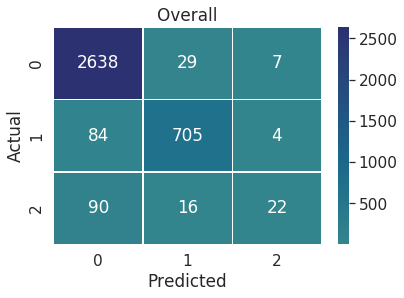

In [90]:
#predict the labels of test data 
y_pred = best_model.predict(X_test)

# count the number of labels
labels = np.unique(y_pred)

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f', center=0.8, cmap='crest', linewidth=.5)
ax.set(title="Overall")

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2674
           1       0.94      0.89      0.91       793
           2       0.67      0.17      0.27       128

    accuracy                           0.94      3595
   macro avg       0.85      0.68      0.72      3595
weighted avg       0.93      0.94      0.93      3595



## Case 2: Training model on UNC data and testing on USC data

In [50]:
train_UNC = df_updated[df_updated['state'] == 'NORTH CAROLINA']
test_USC = df_updated[df_updated['state'] == 'SOUTH CAROLINA']
print(train_UNC.head())
print(test_USC.head())

      year           state                                           sentence  \
1242  1947  NORTH CAROLINA  subject restrictions conditions existing herea...   
1243  1935  NORTH CAROLINA                          powers duties commission.   
1244  1935  NORTH CAROLINA  said textbook purchase rental commission hereb...   
1245  1935  NORTH CAROLINA      acquire contract, and/or purchase, textbooks.   
1246  1935  NORTH CAROLINA  instructional supplies, are, may adopted list ...   

      jim_crow  sent_length  
1242         1          779  
1243         0           32  
1244         0          146  
1245         0           53  
1246         0          218  
   year           state                                           sentence  \
0  1896  SOUTH CAROLINA  shall duty county treasurer report monthly, fi...   
1  1896  SOUTH CAROLINA  moneys disbursed county treasurer account scho...   
2  1896  SOUTH CAROLINA  county treasurer shall make forward state supe...   
3  1896  SOUTH CAROLI

In [51]:
X_train_UNC = train_UNC[['year', 'sentence']]
y_train_UNC = train_UNC['jim_crow']

X_test_USC = test_USC[['year', 'sentence']]
y_test_USC = test_USC['jim_crow']

In [52]:
def objective_new(params):
    params['features__text_pipeline__vect__min_df'] = int(params['features__text_pipeline__vect__min_df'])
    params['dlf__max_depth'] = int(params['dlf__max_depth'])
    params['dlf__min_child_weight'] = int(params['dlf__min_child_weight'])
    params['dlf__scale_pos_weight'] = int(params['dlf__scale_pos_weight'])
    pipeline.set_params(**params)
    
    score = 1-cross_val_score(pipeline, X_train_UNC, y_train_UNC, scoring=make_scorer(f1_score, average="weighted"),
                              n_jobs=-1).mean()
    #print("F1 {:.4f} params {}".format((1-score), params))
    return score

space = {
    'features__text_pipeline__vect__min_df': hp.quniform ('features__text_pipeline__vect__min_df',2,20,1),
    'features__text_pipeline__vect__lowercase': hp.choice('features__text_pipeline__vect__lowercase',[True,False]),
    'features__text_pipeline__vect__ngram_range': hp.choice('features__text_pipeline__vect__ngram_range',[(1,1),(1,2),(1,3),(1,4)]),
    'features__text_pipeline__vect__max_df': hp.uniform('features__text_pipeline__vect__max_df',0.6,0.8),
    'dlf__max_depth': hp.quniform('dlf__max_depth', 2, 10, 1),
    'dlf__min_child_weight': hp.quniform('dlf__min_child_weight', 1, 5, 1),
    'dlf__colsample_bytree': hp.uniform('dlf__colsample_bytree', 0.3, 1.0),
    'dlf__learning_rate': hp.uniform('dlf__learning_rate', 0.05, 1),
    'dlf__scale_pos_weight': hp.quniform('dlf__scale_pos_weight',1,8,1),
    'dlf__gamma': hp.uniform('dlf__gamma',0,2)
    
}

trials = Trials()
best1 = fmin(fn=objective_new,
            space=space,
            algo=tpe.suggest,
            max_evals=100, #actual fit was run with 1000 evals
           trials=trials)

[08:30:45] WARNING: ../src/learner.cc:627:             
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:30:51] WARNING: ../src/learner.cc:627:                                        
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:30:55] WARNING: ../src/learner.cc:627:                                        
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language 

[08:31:56] WARNING: ../src/learner.cc:627:                                          
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:31:58] WARNING: ../src/learner.cc:627:                                          
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:32:00] WARNING: ../src/learner.cc:627:                                          
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some par

[08:35:50] WARNING: ../src/learner.cc:627:                                         
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:35:58] WARNING: ../src/learner.cc:627:                                         
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:36:05] WARNING: ../src/learner.cc:627:                                         
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parame

In [60]:
model_params1 = space_eval(space, best1)
model_params1['features__text_pipeline__vect__min_df'] = int(model_params1['features__text_pipeline__vect__min_df'])
model_params1['dlf__max_depth'] = int(model_params1['dlf__max_depth'])
model_params1['dlf__min_child_weight'] = int(model_params1['dlf__min_child_weight'])
#model_params1['dlf__scale_pos_weight'] = int(model_params1['dlf__scale_pos_weight'])

In [61]:
model_params1

{'dlf__colsample_bytree': 0.47681863557191917,
 'dlf__gamma': 0.003021288593645921,
 'dlf__learning_rate': 0.5727690673683369,
 'dlf__max_depth': 9,
 'dlf__min_child_weight': 1,
 'dlf__scale_pos_weight': 2.0,
 'features__text_pipeline__vect__lowercase': False,
 'features__text_pipeline__vect__max_df': 0.6023428097599217,
 'features__text_pipeline__vect__min_df': 20,
 'features__text_pipeline__vect__ngram_range': (1, 3)}

[10:35:00] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:35:00] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Text(0.5, 1, 'Overall')]

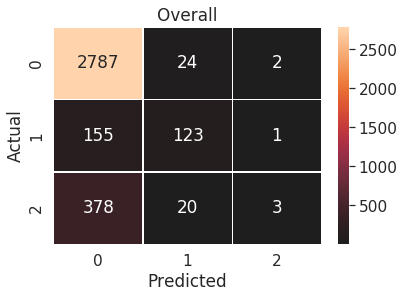

In [62]:
best_model1 = pipeline
best_model1.set_params(**model_params1)
y_pred_USC = best_model1.fit(X_train_UNC,y_train_UNC).predict(X_test_USC)

# count the number of labels
labels = np.unique(y_pred_USC)

data = confusion_matrix(y_test_USC, y_pred_USC)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_USC), index = np.unique(y_test_USC))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f', center=0.8, linewidth=.5)
ax.set(title="Overall")

In [63]:
print(classification_report(y_test_USC, y_pred_USC))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2813
           1       0.74      0.44      0.55       279
           2       0.50      0.01      0.01       401

    accuracy                           0.83      3493
   macro avg       0.69      0.48      0.49      3493
weighted avg       0.79      0.83      0.78      3493



## Predict "label" for the whole corpus

In [2]:
corpus = pd.read_csv('../Split_Cleanup_Updated/updated_results/final_splits_Nov3.csv')

NameError: name 'pd' is not defined

In [65]:
corpus.head()

,id,law_type,state,sentence,length,start_page,end_page,act,section,path
0,1868-69_0000,Act,SOUTH CAROLINA,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...,285,71,71,1,0,https://emailsc.sharepoint.com/:i:/r/sites/COT...
1,1868-69_0001,Act,SOUTH CAROLINA,"Whereas, by an Act of Congress, approved the t...",1161,71,71,1,0,https://emailsc.sharepoint.com/:i:/r/sites/COT...
2,1868-69_0002,Act,SOUTH CAROLINA,Beit enacted by the Senate and House of Repres...,979,71,72,1,1,https://emailsc.sharepoint.com/:i:/r/sites/COT...
3,1868-69_0003,Act,SOUTH CAROLINA,"Upon the passage of this Act, the Governor of ...",197,72,72,1,2,https://emailsc.sharepoint.com/:i:/r/sites/COT...
4,1868-69_0004,Act,SOUTH CAROLINA,"In the Senate House, the twentysecond day of J...",122,72,72,1,1,https://emailsc.sharepoint.com/:i:/r/sites/COT...


In [75]:
# corpus_df = corpus[['id', 'sentence']]
# corpus_df.head()

,id,sentence
0,1868-69_0000,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...
1,1868-69_0001,"Whereas, by an Act of Congress, approved the t..."
2,1868-69_0002,Beit enacted by the Senate and House of Repres...
3,1868-69_0003,"Upon the passage of this Act, the Governor of ..."
4,1868-69_0004,"In the Senate House, the twentysecond day of J..."


In [76]:
# len(corpus_df)

403481

In [137]:
# corpus_df['id']=corpus_df['id'].str.split('_')
# corpus_df.dtypes

corpus['year']=corpus_df['id'].str.split('_')
corpus.dtypes

id             object
law_type       object
state          object
sentence       object
length          int64
start_page      int64
end_page        int64
act             int64
section        object
path           object
year          float64
dtype: object

In [1]:
id = []
for i in corpus['year']:
        id.append(i[0])


NameError: name 'corpus' is not defined

In [79]:
print(len(id))
print(type(id))

403481
<class 'list'>


In [80]:
print(len(list(set(id))))
list(set(id))

100


['1896',
 '1889',
 '1932',
 '1871-1872',
 '1953',
 '1956',
 '1968',
 '1906',
 '1925',
 '1949',
 '1947',
 '1881-82',
 '1879',
 '1891',
 '1878',
 '1941',
 '1948',
 '1933',
 '1923',
 '1873',
 '1937',
 '1955',
 '1927',
 '1905',
 '1902',
 '1897',
 '1964',
 '1892',
 '1924',
 '1951',
 '1919',
 '1890',
 '1886-1887',
 '1910',
 '1899',
 '1874',
 '1868-69',
 '1872-1873',
 '1958',
 '1904',
 '1938',
 '1911',
 '1966',
 '1883',
 '1877-78',
 '1944',
 '1929',
 '1959',
 '1957',
 '1946',
 '1943',
 '1950',
 '1871',
 '1942',
 '1873-1874',
 '1952',
 '1965',
 '1922',
 '1907',
 '1931',
 '1870-1871',
 '1880',
 '1960',
 '1914',
 '1909',
 '1958b',
 '1918',
 '1967',
 '1940',
 '1915',
 '1900',
 '1901',
 '1893',
 '1928',
 '1869-1870',
 '1961',
 '1936',
 '1920',
 '1875-76',
 '1921',
 '1912',
 '1945',
 '1884',
 '1954',
 '1888',
 '1926',
 '1894',
 '1917',
 '1908',
 '1939',
 '1903',
 '1934',
 '1916',
 '1898',
 '1913',
 '1962',
 '1885',
 '1930',
 '1963',
 '1935']

In [81]:
id_new=[]
for i in id:
    if i.find('-') != -1:
        year = i.split('-')[0]
        id_new.append(year)
    else:
        id_new.append(i)

In [84]:
len(list(set(id_new)))

98

#### Replace the 2-year pairs with single years:
- '1868-69' --> 1868
- '1869-1870' --> 1869
- '1870-1871' --> 1870
- '1871-1872' --> 1871
- '1872-1873' --> 1872
- '1873-1874' --> 1873
- '1875-76'   --> 1875
- '1877-78'   --> 1877
- '1881-82'   --> 1881
- '1886-1887' --> 1886
- '1958b'     --> 1958

In [85]:
corpus_df['year'] = id_new
ct_year = corpus_df['year'].unique()
print(ct_year)
print(len(ct_year))

['1868' '1869' '1870' '1871' '1872' '1873' '1874' '1875' '1877' '1878'
 '1879' '1880' '1881' '1883' '1884' '1885' '1886' '1888' '1889' '1890'
 '1891' '1892' '1893' '1894' '1896' '1897' '1898' '1899' '1900' '1901'
 '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909' '1910' '1911'
 '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919' '1920' '1921'
 '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929' '1930' '1931'
 '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939' '1940' '1941'
 '1942' '1943' '1944' '1945' '1946' '1947' '1948' '1949' '1950' '1951'
 '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1958b' '1959' '1960'
 '1961' '1962' '1963' '1964' '1965' '1966' '1967' '1968']
98


In [86]:
# Change 'year' 1958b to 1958
corpus_df.replace('1958b', '1958', inplace=True)

In [89]:
print(corpus_df['year'].unique())
print(len(corpus_df['year'].unique()))

['1868' '1869' '1870' '1871' '1872' '1873' '1874' '1875' '1877' '1878'
 '1879' '1880' '1881' '1883' '1884' '1885' '1886' '1888' '1889' '1890'
 '1891' '1892' '1893' '1894' '1896' '1897' '1898' '1899' '1900' '1901'
 '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909' '1910' '1911'
 '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919' '1920' '1921'
 '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929' '1930' '1931'
 '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939' '1940' '1941'
 '1942' '1943' '1944' '1945' '1946' '1947' '1948' '1949' '1950' '1951'
 '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1959' '1960' '1961'
 '1962' '1963' '1964' '1965' '1966' '1967' '1968']
97


In [106]:
X_test_corpus = corpus_df[['year', 'sentence']]
X_test_corpus.head()

,year,sentence
0,1868,AN ACT ACCEPTING THE BENEFITS OF AN ACT DONATI...
1,1868,"Whereas, by an Act of Congress, approved the t..."
2,1868,Beit enacted by the Senate and House of Repres...
3,1868,"Upon the passage of this Act, the Governor of ..."
4,1868,"In the Senate House, the twentysecond day of J..."


In [107]:
X_test_corpus.dtypes

year        object
sentence    object
dtype: object

In [108]:
# Change the datatype of "year" and "jim_crow" to string in new_df1 
X_test_corpus[['sentence']] = X_test_corpus[['sentence']].astype(str)
X_test_corpus[['year']] = X_test_corpus[['year']].astype(int)

In [109]:
# Convert column 'sentence' to lowercase use map()
X_test_corpus['sentence'] = X_test_corpus['sentence'].map(str.lower)


In [110]:
X_test_ml = X_test_corpus

In [111]:
p_corpus=[]

# Remove stopwords from the 'sentence' column of the dataframe
new_sentences=[]
for i in X_test_ml['sentence']:
    p_corpus.append(remove_stop_words(i))
X_test_ml['sentence'] = p_corpus

In [132]:
#predict the labels of test data 
y_pred_corpus = best_model.predict(X_test_ml)

# count the number of labels
corpus_df['predicted_label'] = y_pred_corpus


In [135]:
# Save the corpus with predicted data in a csv file
corpus_df.to_csv("Predicted_Data_Labels/PredLabels_corpus.csv")
len(corpus_df)

403481

In [136]:
for i, g in X_test_corpus.groupby('year')['sentence', 'predicted_label']:
    print(g)
    g.to_csv(f'Predicted_Data_Labels/{year}.csv')

      year                                           sentence  predicted_label
0     1868  act accepting benefits act donating public lan...                0
1     1868  whereas, act congress, approved twentythird da...                0
2     1868  beit enacted senate house representatives stat...                0
3     1868  upon passage act, governor state authorized ta...                0
4     1868  senate house, twentysecond day july, year lord...                0
...    ...                                                ...              ...
1360  1868  words purporting give joint authority three pu...                0
1361  1868  6th. word sworn, applied public officers, shal...                0
1362  1868  ct shall construed interfere chartered rights ...                0
1363  1868  chartered cities villages, except city charles...                0
1364  1868                  bridges shall construed giving au                0

[1365 rows x 3 columns]
      year                 

       year                                           sentence  \
26719  1883      act vo recuartrer biytiues gar turnerxe roan.   
26720  1883  enacted senate house representatives state sou...   
26721  1883  senate house, nineteenth day december, year lo...   
26722  1883                  j. c. sheppard, president senate.   
26723  1883  james simons, speaker house representatives ap...   
...     ...                                                ...   
28651  1883  said town council shall authorized appoint one...   
28652  1883  nothing section con tained shall construed aut...   
28653  1883  4. words, said intendant war dens shall, colle...   
28654  1883  5. act entitled act amend charter town pendlet...   
28655  1883  james simons, speaker house representatives. a...   

       predicted_label  
26719                0  
26720                0  
26721                0  
26722                0  
26723                0  
...                ...  
28651                0  
28652  

       year                                           sentence  \
52701  1897  231, act amend section 21 code civil procedure...   
52702  1897  enacted general assembly state south carolina,...   
52703  1897  circuit courts fourth circuit year a. d. 1897,...   
52704  1897  court general sessions county horry conway fir...   
52705  1897  court general sessions county marion marion se...   
...     ...                                                ...   
53981  1897  addition, shall powers duties prescribed secti...   
53982  1897  constable appointed glendale manufacturing com...   
53983  1897  terms office said constables shall two years s...   
53984  1897  396. act validate election intendant wardens t...   
53985  1897  enacted general assembly state south carolina,...   

       predicted_label  
52701                0  
52702                0  
52703                0  
52704                0  
52705                0  
...                ...  
53981                0  
53982  

       year                                           sentence  \
80102  1912  298. act tro amend act enxtitltep act est.slis...   
80103  1912  enacted general assembly state south carolina,...   
80104  1912  be, hereby, amended read follows: section 4. w...   
80105  1912  commitment act, whether judge, magistrate, par...   
80106  1912  boy committed said institution, provisions act...   
...     ...                                                ...   
83285  1912  record shall lettered numbered said commission...   
83286  1912  chief commissioner county commissioners aiken ...   
83287  1912  5 5. acts parts acts inconsistent herewith her...   
83288  1912  6. act shall go effect immediately approval go...   
83289  1912  570 act provive payment florence county land a...   

       predicted_label  
80102                0  
80103                0  
80104                1  
80105                0  
80106                2  
...                ...  
83285                0  
83286  

        year                                           sentence  \
119569  1922  436. act amend section 748 code laws 1912, vol...   
119570  1922  criminal code, 1912, amended term office game ...   
119571  1922  governor state shall appoint, upon recommendat...   
119572  1922  nonmigratory fish game wardens, whose term off...   
119573  1922  governor shall issue commission person appoint...   
...      ...                                                ...   
124949  1922  board shall organize annual election electing ...   
124950  1922  whenever vacancy shall occur said board, death...   
124951  1922              act amendeddisbursement school funds.   
124952  1922  said section 6 said act (approved december 22n...   
124953  1922  moneys assessed collected school purposes shal...   

        predicted_label  
119569                0  
119570                0  
119571                0  
119572                0  
119573                0  
...                 ...  
124949       

        year                                           sentence  \
200940  1937  1. act relating sale disposition securities st...   
200941  1937  definitions.be enacted general assembly state ...   
200942  1937  (2) person shall include natural person, corpo...   
200943  1937  used herein term trust shall include trust cre...   
200944  1937  (3) sale sell shall include every disposition,...   
...      ...                                                ...   
205266  1937  provided, further, shall unlawful board truste...   
205267  1937  state treasurer comptroller general, request s...   
205268  1937  provided, school district may appeal decision ...   
205269  1937  fach school also allowed supervision incidenta...   
205270  1937  3.this act shall take effect immediately upon ...   

        predicted_label  
200940                0  
200941                0  
200942                0  
200943                0  
200944                0  
...                 ...  
205266       

        year                                           sentence  \
242209  1947  69 acts general assembly south carolina, 1945,...   
242210  1947  act 69 1945 amendedpay circuit court jurors, b...   
242211  1947  69 acts general assembly south: carolina, 1945...   
242212  1947  time effectivethis act shall take effect upon ...   
242213  1947  (r7, $20, h114) no, 2 act amend section 45691,...   
...      ...                                                ...   
246083  1947  end term office original board members thereof...   
246084  1947  board shall serve without compensation, except...   
246085  1947  said boardis authorized empowered acquire, own...   
246086  1947  said board empowered assess collect rentals fe...   
246087  1947  repeal.aall acts parts acts inconsistent provi...   

        predicted_label  
242209                0  
242210                0  
242211                0  
242212                0  
242213                0  
...                 ...  
246083       

        year                                           sentence  \
328994  1959  1 act regulate trawling shrimp crabs opposite ...   
328995  1959  unlawful trawl shrimp crabs certain areas cert...   
328996  1959  section shall apply portion hilton head island...   
328997  1959  division fisheries shall place stake piling, a...   
328998  1959  act 403 1957 applicable hilton head islandthe ...   
...      ...                                                ...   
337552  1959  employee officeholder violating provision supp...   
337553  1959  equipment belonging york county designated roa...   
337554  1959  york county attorney shali represent agencies,...   
337555  1959  audit shali made annually, copy furnished memb...   
337556  1959  section a1. act shall take effect upon approva...   

        predicted_label  
328994                0  
328995                0  
328996                0  
328997                1  
328998                0  
...                 ...  
337552       

In [123]:
corpus_by_year

In [ ]:
for g in corpus_by_year:
    